In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
import dask
from dask.diagnostics import ProgressBar

# Load saved results

In [16]:
def preprocess(ds):
    ds = ds.rename({'Duration':'duration','Gamma':'gamma','Tp':'tp','Seed':'seed'})
    ds = ds.assign_coords({'duration':ds['duration'],'gamma':ds['gamma'],'tp':ds['tp'],'seed':range(len(ds['seed']))})
    return ds
fn = 'RAS_n10000_2Hz_fixedres.zarr'
ds = preprocess(xr.open_zarr(fn))

ds['TzTp'] = ds['Tz']/ds['tp']
ds['HmHs'] = ds['Hmax']/ds['Hs']

ds = ds.stack(N=['duration','tp'])
ds['N'] = ds['duration']/ds['tp']

ds = ds.sortby('N')
ds = ds.set_index({'N':'N'})
ds = ds.set_coords('N')

ds = ds.load()
# ds
ds_std = ds.std(dim='seed')
ds_mean = ds.mean(dim='seed')
ds_max = ds.max(dim='seed')
ds_CV = ds_std/ds_mean
ds_CV = ds_CV.drop('this_seed')
ds_CV = ds_CV.load()

# Look at averaged statistics

In [ ]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')

In [ ]:
layout=[]
for v in ds_mean.data_vars:
    p=ds_mean[v].hvplot.scatter(x='N',by='gamma',width=350,height=450).opts(logx=True, logy=True)
    layout.append(p)
layout = hv.Layout(layout).cols(3)
display(layout)

In [ ]:
layout=[]
for v in ds_std.data_vars:
    p=ds_std[v].hvplot.scatter(x='N',by='gamma',width=350,height=450).opts(logx=True,logy=True)
    layout.append(p)
layout = hv.Layout(layout).cols(3)
display(layout)

In [ ]:
layout=[]
for v in ds_CV.data_vars:
    p=ds_CV[v].hvplot.scatter(x='N',by='gamma',width=350,height=450).opts(logx=True, logy=True)
    layout.append(p)
layout = hv.Layout(layout).cols(3)
display(layout)

In [ ]:
vv={'Hs':(0.5,1.5),'Hmax':(0.5,2.25),'HmHs':(0.75,2.25),'r':(-0.25,1)}

nn=[slice(10,20),slice(20,30),slice(30,40),slice(40,80),slice(80,120),slice(120,300),slice(300,450)]

fig,axs = plt.subplots(len(nn),len(vv),figsize=(10,10))

colors=sns.color_palette().as_hex()

for j,v in enumerate(vv.keys()):
    for i,n in enumerate(nn):
        ax = axs[i,j]
        bins=np.linspace(*vv[v],num=100)

        sample1 = ds.sel(gamma=1).sel(N=n).stack(sample=['N','seed'])[v]
        sns.histplot(sample1,ax = ax,stat='density',element='bars',edgecolor=None,bins=bins,color=colors[0],alpha=0.5)
        ncoeffs = norm.fit(sample1)
        nfitted = norm.pdf(bins,*ncoeffs)
        ax.plot(bins,nfitted,ls='--',lw=1.5,color=colors[0])

        sample2 = ds.sel(gamma=6).sel(N=n).stack(sample=['N','seed'])[v]
        sns.histplot(sample2,ax = ax,stat='density',element='bars',edgecolor=None,bins=bins,color=colors[1],alpha=0.5)
        ncoeffs = norm.fit(sample2)
        nfitted = norm.pdf(bins,*ncoeffs)
        ax.plot(bins,nfitted,ls='--',lw=1.5,color=colors[1])

        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim(vv[v])
        ax.set_xticklabels([])

        if j == 0:
            ax.set_ylabel(f'Density\nN = [{n.start}, {n.stop}]')
        # if i == 0:
            
        if i == len(nn)-1:
            ax.set_xticklabels(ax.get_xticks())
            ax.set_xlabel(f'{v}')

        # break

fig.tight_layout()


# Unconstrained fits... fails a bit

In [ ]:
def fit_dist(sample,dist):
    coeffs = dist.fit(sample)
    return np.array(coeffs)

In [ ]:
distn={'Hs':gamma,'Hmax':weibull_max,'HmHs':weibull_max}
ds_chunked = ds.chunk({'gamma':-1,'N':1,'seed':-1})

fits = xr.Dataset()
for v,dist in distn.items():
    fits[v] = xr.apply_ufunc(fit_dist,
                            ds_chunked[v],
                            dist,
                            input_core_dims=[['seed'],[]],
                            output_core_dims=[['coeffs']],
                            vectorize=True,
                            dask='parallelized',
                            output_dtypes=['float'],
                            dask_gufunc_kwargs=dict(output_sizes=dict(coeffs=3))
                            )
fits

In [ ]:
with dask.config.set(scheduler='processes'):
    with ProgressBar():
        fits = fits.compute()

In [ ]:
limits=[30,5,5]
layout = []
for c in range(len(fits.coeffs)):
    for v in ['Hmax','HmHs']:
        data = fits[v].isel(coeffs=c)
        data = data.where(data<limits[c])
        p=data.hvplot.scatter(x='N',by='gamma',alpha=0.75,line_color=None,width=400,height=300).opts(logx=True,logy=True)
        layout.append(p)
layout=hv.Layout(layout).cols(2)
display(layout)

In [ ]:
limits=[1000,5,5]
layout = []
for c in range(len(fits.coeffs)):
    for v in ['Hs']:
        data = fits[v].isel(coeffs=c)
        data = data.where(data<limits[c])
        p=data.hvplot.scatter(x='N',by='gamma',alpha=0.75,line_color=None,width=400,height=300).opts(logx=True,logy=True)
        layout.append(p)
layout=hv.Layout(layout).cols(1)
display(layout)

# Examine the effects of constraining the fits by expected variations with N

In [ ]:
from scipy.stats import fit
v='Hs'
N=10.
subset=ds[v].sel(gamma=1.0)
sample1 = subset.sel(N=N)

bounds = [(N,N),(1E-5,1),(1E-4,1)]
fr = fit(gamma,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

subset=ds[v].sel(gamma=6.5)
sample1 = subset.sel(N=N)

bounds = [(N,N),(1E-5,1),(1E-4,1)]
fr = fit(gamma,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()

In [ ]:
v='HmHs'
N=10.
subset=ds[v].sel(gamma=6.5)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

subset=ds[v].sel(gamma=1.0)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()


N=100.
subset=ds[v].sel(gamma=6.5)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

subset=ds[v].sel(gamma=1.0)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

# Bounded Fits

In [22]:
def fit_Hs(sample,N):
    bounds = [(N,N),(1E-5,1),(1E-5,1)]
    fr = ss.fit(ss.gamma,sample,bounds)
    if fr.success:
        coeffs = [p for p in fr.params]
    else:
        coeffs = [np.nan, np.nan, np.nan]
    coeffs.append(fr.nllf())
    return np.array(coeffs)

def fit_Hmax(sample,N,plot=False):
    bounds = [(0.1,40),(1,8),(np.log(N)/(2**0.5),np.log(N)/(2**0.5))]
    # bounds = [(0.1,50),(7/8*np.log(N)+2/3,7/8*np.log(N)+2/3),(np.log(N)/(2**0.5),np.log(N)/(2**0.5))]
    fr = ss.fit(ss.weibull_max,sample,bounds)
    if fr.success:
        coeffs = [p for p in fr.params]
    else:
        coeffs = [np.nan, np.nan, np.nan]
    coeffs.append(fr.nllf())
    if plot:
        fr.plot()
    return np.array(coeffs)

def fit_Hmax2(sample,N,plot=False):
    # bounds = [(0.1,40),(1,8),(np.log(N)/(2**0.5),np.log(N)/(2**0.5))]
    bounds = [(0.1,50),(7/8*np.log(N)+2/3,7/8*np.log(N)+2/3),(np.log(N)/(2**0.5),np.log(N)/(2**0.5))]
    fr = ss.fit(ss.weibull_max,sample,bounds)
    if fr.success:
        coeffs = [p for p in fr.params]
    else:
        coeffs = [np.nan, np.nan, np.nan]
    coeffs.append(fr.nllf())
    if plot:
        fr.plot()
    return np.array(coeffs)

def fit_HmHs(sample,N):
    bounds = [(1,30),(1,4),(np.sqrt(np.log(N/2)),np.sqrt(np.log(N/2)))]
    # bounds = [(1,30),(1.71*np.sqrt(np.log(N))-0.25,1.71*np.sqrt(np.log(N))-0.25),(np.sqrt(np.log(N/2)),np.sqrt(np.log(N/2)))]
    fr = ss.fit(ss.weibull_max,sample,bounds)
    if fr.success:
        coeffs = [p for p in fr.params]
    else:
        coeffs = [np.nan, np.nan, np.nan]
    coeffs.append(fr.nllf())
    return np.array(coeffs)


In [23]:
distn={'Hs':fit_Hs,'Hmax':fit_Hmax,'HmHs':fit_HmHs}
ds_chunked = ds.chunk({'gamma':-1,'N':1,'seed':-1})#.isel(gamma=slice(0,4))
fits = xr.Dataset()
for v,fit_fn in distn.items():
    fits[v] = xr.apply_ufunc(fit_fn,
                            ds_chunked[v],
                            ds_chunked[v].N,
                            input_core_dims=[['seed'],[]],
                            output_core_dims=[['coeffs']],
                            vectorize=True,
                            dask='parallelized',
                            output_dtypes=['float'],
                            dask_gufunc_kwargs=dict(output_sizes=dict(coeffs=4))
                            )
# fits = fits['Hs']

In [24]:
with dask.config.set(scheduler='processes'):
    with ProgressBar():
        fits = fits.compute()

fits.to_netcdf('ModelFitCoefficients_SingleFixed.nc')

[########################################] | 100% Completed | 266.12 s


In [25]:
fits = xr.open_dataset('ModelFitCoefficients_SingleFixed.nc')

In [ ]:
sample=ds_chunked.sel(gamma=6.5).isel(N=15)['Hmax']
print(sample.N)
fit_Hmax(sample,N=sample.N,plot=True)
fit_Hmax2(sample,N=sample.N,plot=True)

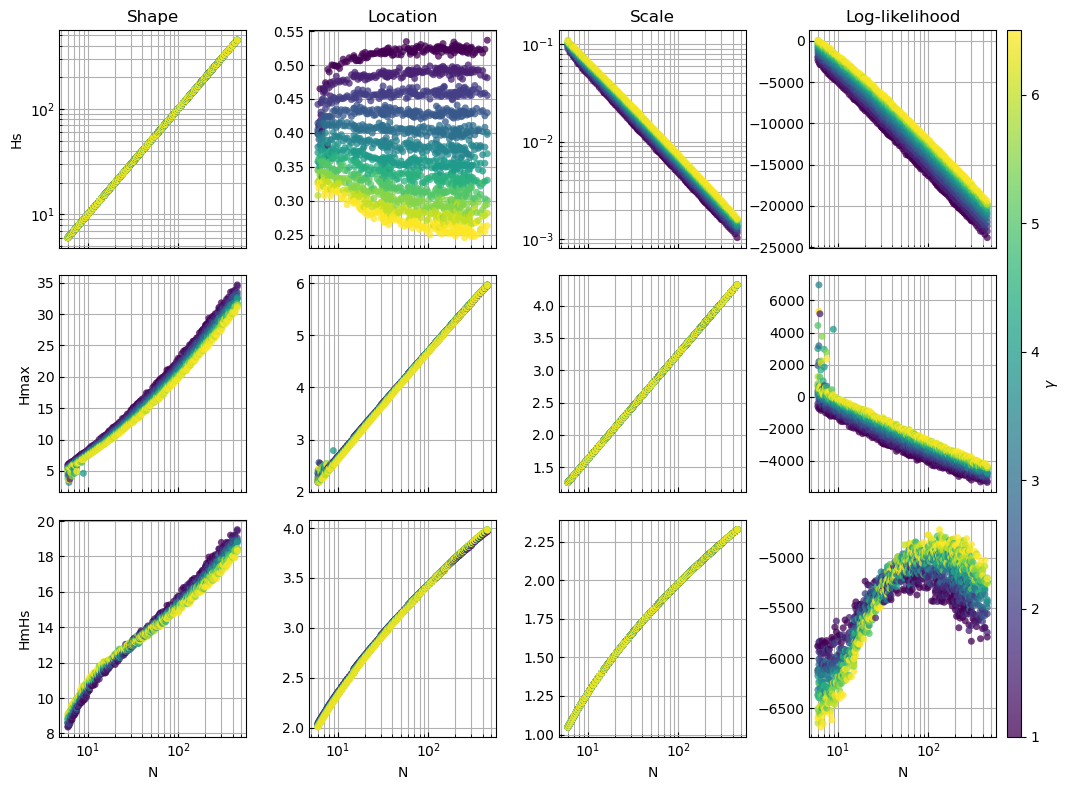

In [27]:
fig,axs = plt.subplots(3,4,figsize=(12,8),sharex=True)
for i,v in enumerate(['Hs','Hmax','HmHs']):
    for c in range(len(fits.coeffs)):
        ax = axs[i,c]
        data = fits.isel(coeffs=c)
        p=data.plot.scatter(ax=ax,x='N',y=v,hue='gamma',edgecolor='none',alpha=0.75,s=25,add_guide=False,zorder=100)
        ax.set_xscale('log')
        if c in [0,2] and (v == 'Hs'):
            ax.set_yscale('log')
        # if (c != 3) and v not in ['Hmax', 'HmHs']:
        #     ax.set_yscale('log')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(which='both',direction='in')
        ax.grid(which='both')
        
        if c == 0:
            ax.set_ylabel(v)
        if i == 2:
            ax.set_xlabel('N')
# axs[0,0].legend(p)
axs[0,0].set_title('Shape')
axs[0,1].set_title('Location')
axs[0,2].set_title('Scale')
axs[0,3].set_title('Log-likelihood')
fig.tight_layout()
cb=fig.colorbar(p,ax=axs,pad=0.01,aspect=50)
cb.set_label('$\gamma$')
# fig.

# Estimate parametric model for distributions as a function of Gamma and N 

In [28]:
import statsmodels.formula.api as smf

In [29]:
def summary2xarray(summary2, gamma):

    #Convert summary stats table
    vv1=summary2.tables[0].iloc[:,[0,1]].set_index(0).T.rename(index={1:gamma})
    vv2=summary2.tables[0].iloc[:,[2,3]].set_index(2).T.rename(index={3:gamma})
    df = pd.concat([vv1,vv2],axis=1)
    for c in df.columns:
        # print(c)
        if c == "Date:":
            df[c] = pd.to_datetime(df[c].astype(str))
        elif c in ['Model:','Dependent Variable:']:
            df[c] = df[c].astype(str).convert_dtypes()
        else:
            df[c] = pd.to_numeric(df[c].astype(str).str.strip())

    ds_stats = xr.Dataset(df).rename({'dim_0':'gamma'})

    # Convert the coefficients table
    ds_fits = xr.Dataset(summary2.tables[1]).rename({'dim_0':'coeff'}).expand_dims({'gamma':[gamma,]})
    
    ds = xr.merge([ds_stats,ds_fits])

    return ds

# summary2xarray(fr.summary2(),float(gamma))

In [30]:
min_N = 15
model_fits = fits.sel(N=slice(min_N,None))

In [129]:
def get_transform(t):
    if t == 'noop':
        return lambda x:x, ''
    elif t == 'log':
        return np.log10, '\log'

def gamma_model(data,ytran='noop',xtran='log',xpow=1.,plot=False,v='',p=''):

    if plot:
        fig1,ax = plt.subplots(figsize=(6,6))
    else:
        fig1 = None

    results = []
    handles = []
    for gamma in data.gamma:
        this_data = data.sel(gamma=gamma)

        xt, xl = get_transform(xtran)
        yt, yl = get_transform(ytran)

        y=yt(this_data.values)
        x=xt(this_data.N.values)**xpow

        if xpow != 1.: 
            xlabel = f'$({xl}N)^{{{xpow}}}$'
        else: 
            xlabel = f'${xl}N$'
        ylabel = f'${yl}{p}$'

        X = sm.add_constant(x)
        ols = sm.OLS(y,X)
        fr = ols.fit()
        results.append(summary2xarray(fr.summary2(),float(gamma)))
        
        if plot:
            plt.scatter(x,y,alpha=0.5)
            y_hat=ols.predict(fr.params,X)
            plt.plot(x,y_hat,label=float(gamma))
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

    ds_results = xr.merge(results)

    # Finally establish gamma dependance
    gamma_results =[] 
    if plot:
        fig2,axs = plt.subplots(1,2,figsize=(7,3))
    else:
        fig2 = None

    eqn=[]
    for ax,gc in zip(axs,ds_results.coeff):
        y = ds_results['Coef.'].sel(coeff=gc).values
        x = ds_results['gamma']
        X = x.to_dataframe()
        X['gamma2'] = X['gamma']**2
        X['Intercept'] = 1
        ols = sm.OLS(y,X)
        fr = ols.fit()

        gamma_results.append(summary2xarray(fr.summary2(),str(gc.values)))

        fp = fr.params
        e = f'${fp.gamma2:.1E}\gamma^2 + {fp.gamma:.1E}\gamma + {fp.Intercept:.1E}$'
        eqn.append(e)

        if plot:
            ax.scatter(x,y,alpha=0.5)
            y_hat=ols.predict(fp,X)
            ax.plot(x,y_hat)
            ax.set_xlabel('$\gamma$')
            ax.set_ylabel(gc.values)
            ax.set_title(e,fontsize=10)

    eqn_text = f'Variable : ${v}$\n{ylabel} = x1.{xlabel} + const'
    
    if plot:
        lax=fig1.legend(loc='upper left', bbox_to_anchor=(1.0, 0.95))
        lax.set_title('$\gamma$')
        fig1.axes[0].set_title(f'Variable : ${v}$, Parameter: ${p}$')
        fig1.tight_layout()

        fig2.suptitle(eqn_text)
        fig2.tight_layout()
        
    ds_gamma = xr.merge(gamma_results)
    
    return ds_results, ds_gamma, fig1, fig2


c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


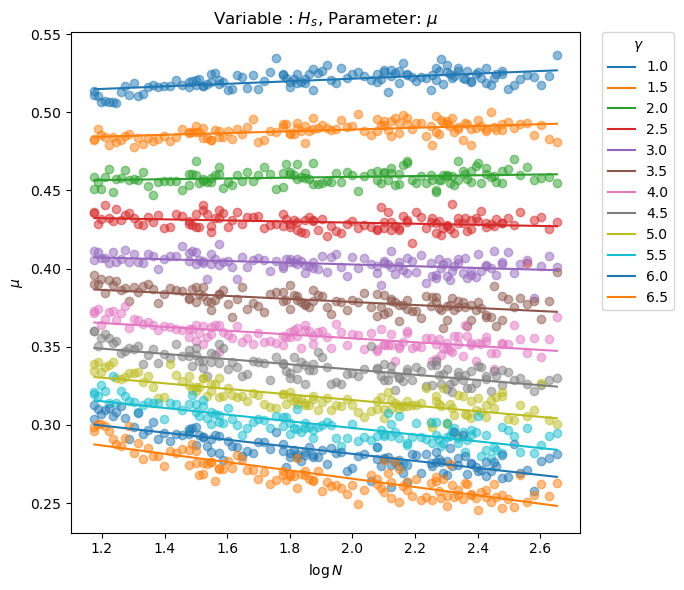

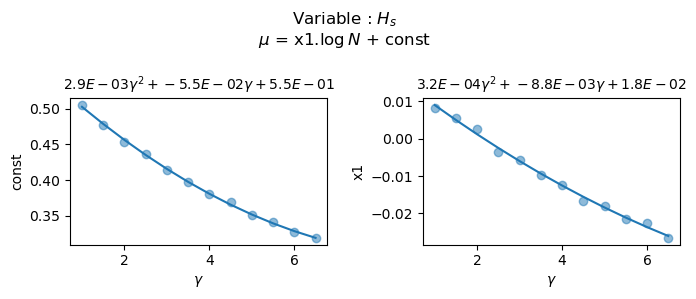

In [130]:
data = model_fits['Hs'].isel(coeffs=1)
ds_results, ds_gamma, fig1, fig2 = gamma_model(data,ytran='noop',xtran='log',xpow=1.0,plot=True,v='H_s',p='\mu')

c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


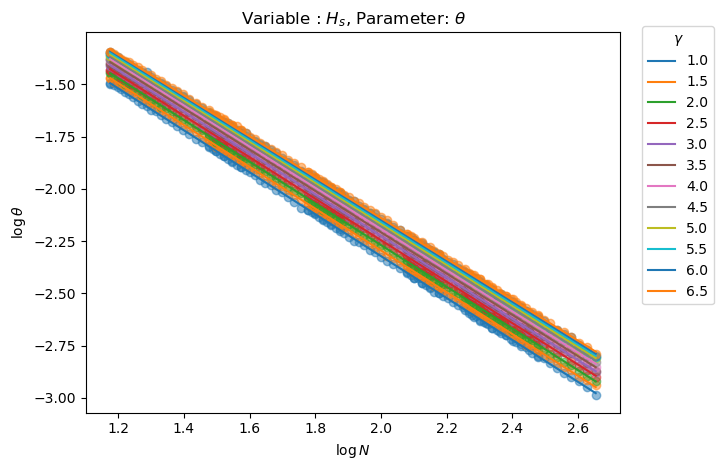

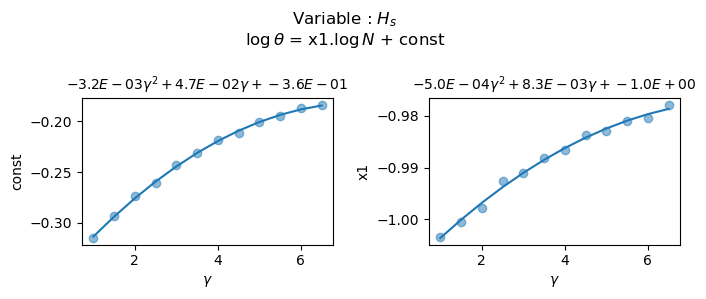

In [122]:
data = model_fits['Hs'].isel(coeffs=2)
ds_results, ds_gamma, fig1, fig2 = gamma_model(data,ytran='log',xtran='log',xpow=1.0,plot=True,v='H_s',p='\\theta')

c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


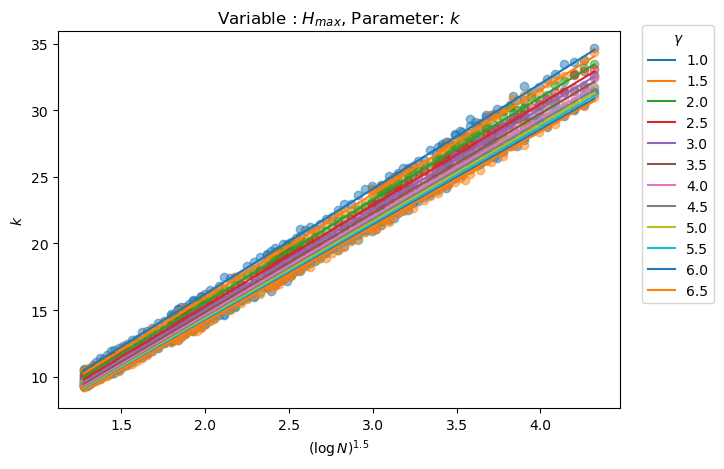

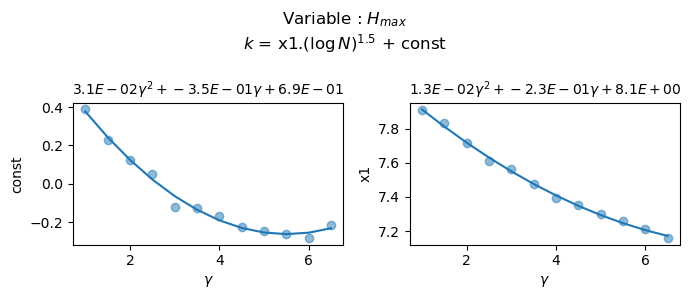

In [123]:
data = model_fits['Hmax'].isel(coeffs=0)
ds_results, ds_gamma, fig1, fig2 = gamma_model(data,ytran='noop',xtran='log',xpow=1.5,plot=True,v='H_{max}',p='k')

c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


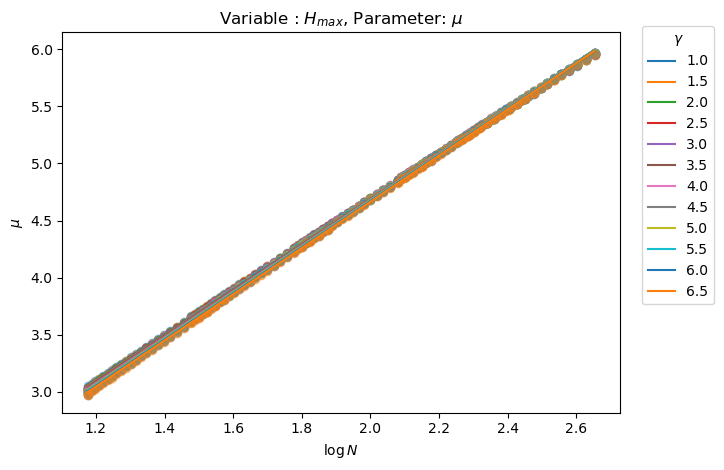

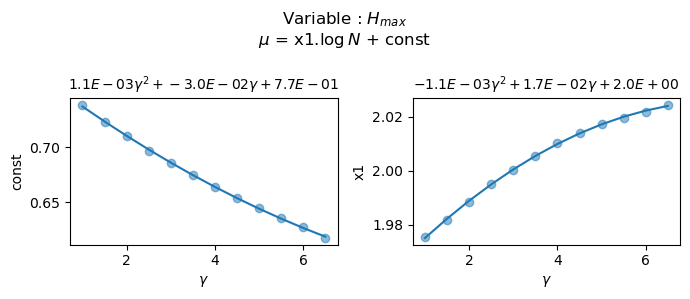

In [124]:
data = model_fits['Hmax'].isel(coeffs=1)
ds_results, ds_gamma, fig1, fig2 = gamma_model(data,ytran='noop',xtran='log',xpow=1.,plot=True,v='H_{max}',p='\mu')

c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


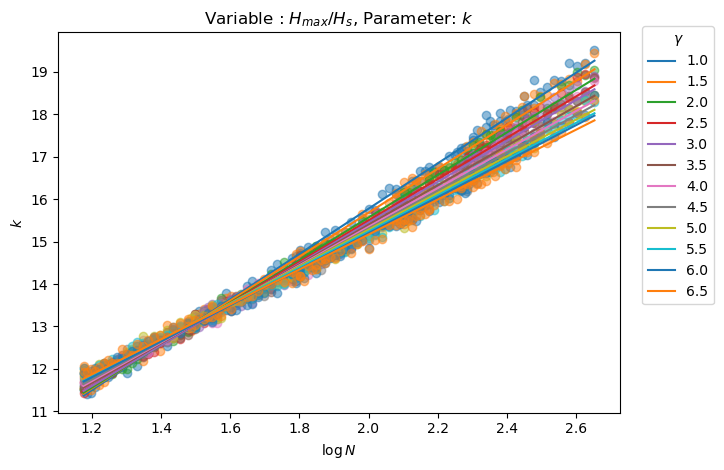

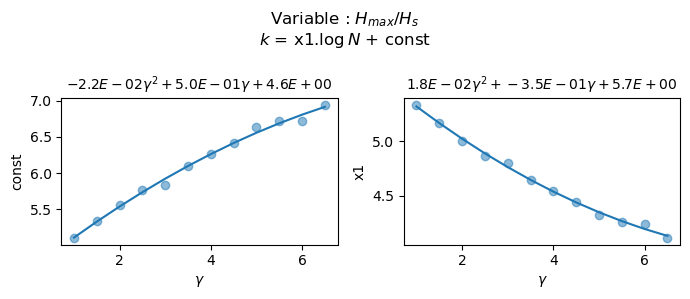

In [125]:
data = model_fits['HmHs'].isel(coeffs=0)
ds_results, ds_gamma, fig1, fig2 = gamma_model(data,ytran='noop',xtran='log',xpow=1.,plot=True,v='H_{max}/H_s',p='k')

c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\bransonp\Anaconda3\envs\spectem\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


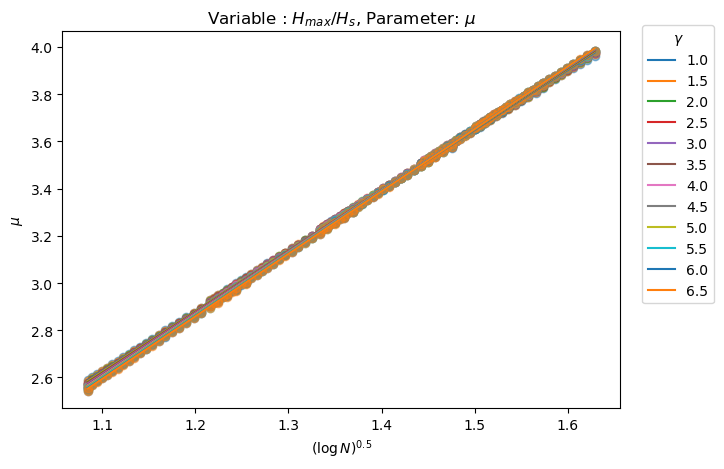

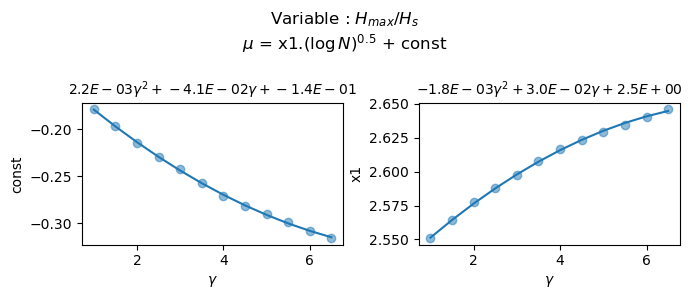

In [126]:
data = model_fits['HmHs'].isel(coeffs=1)
ds_results, ds_gamma, fig1, fig2 = gamma_model(data,ytran='noop',xtran='log',xpow=0.5,plot=True,v='H_{max}/H_s',p='\mu')